In [1]:
import os
from typing import TypedDict, Annotated, List, Literal

In [2]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

In [3]:
from langchain_core.messages import HumanMessage, AIMessage

In [4]:
llm = ChatOpenAI(model='gpt-4o-mini')

In [5]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages is in the conversation"]
    city: str
    start_date: str
    end_date: str
    kind_of_trip: Literal["solo trip", "partner trip", "friendship trip", "family trip"]
    with_pets: bool
    interests: List[str]
    itinerary: str

In [6]:
gen_itinerary_prompt_template = """
You are a helpful travel assistant. Your task is to create a day-by-day trip itinerary in markdown format based on user input. The user input includes city, start date, end date, kind of trip (solo, partner, friendship, or family), with pets or not, interests.
The itinerary should be concise, include suggested activities for each day, and tailored to the user's preferences.
Here is the user input:
- City: {city}
- Start date: {start_date}
- End date: {end_date}
- Kind of trip: {kind_of_trip}
- With pets: {with_pets}
- Interests: {interests}

"""

gen_itinerary_prompt = ChatPromptTemplate.from_template(gen_itinerary_prompt_template)

In [7]:
def input_city(state: PlannerState) -> PlannerState:
    print("Please enter the city you want to visit for your day trip:")
    city = input("City: ")
    print(city)
    
    return {
        **state,
        "city": city,
        "messages": state['messages'] + [HumanMessage(content=city)]
    }

In [8]:
def input_trip_dates(state: PlannerState) -> PlannerState:
    print("Please enter your trip start date (DD-MM-YYYY):", end = " ")
    start_date = input("Start Date: ")
    print(start_date) 

    print("Please enter your trip end date (DD-MM-YYYY):", end = " ")
    end_date = input("End Date: ")
    print(end_date)
    
    return {
        **state,
        "start_date": start_date,
        "end_date": end_date,
        "messages": state['messages'] + [
            HumanMessage(content=f"Start Date: {start_date}"),
            HumanMessage(content=f"End Date: {end_date}")
        ]
    }

def input_trip_type(state: PlannerState) -> PlannerState:
    print("What type of trip are you planning? (Options: solo trip, partner trip, friendship trip, family trip)")
    trip_type = input("Your choice: ").strip().lower()
    print(trip_type)
    
    if trip_type not in ["solo trip", "partner trip", "friendship trip", "family trip"]:
        print("Invalid input. Please choose one of the available options.")
        return input_trip_type(state)
    
    return {
        **state,
        "kind_of_trip": trip_type,
        "messages": state['messages'] + [HumanMessage(content=f"Trip Type: {trip_type}")]
    }

def input_with_pets(state: PlannerState) -> PlannerState:
    print("Will you bring pets along? (yes/no):")
    user_response = input("Your response: ").strip().lower()
    with_pets = user_response == "yes"
    print(with_pets)
    
    return {
        **state,
        "with_pets": with_pets,
        "messages": state['messages'] + [HumanMessage(content=f"With Pets: {user_response}")]
    }

def input_interests(state: PlannerState) -> PlannerState:
    print("What are your interests for this trip? (e.g., food, history, adventure, nature):")
    interests = input("Your interests (comma-separated): ").strip().lower().split(", ")
    print(interests)
    
    return {
        **state,
        "interests": interests,
        "messages": state['messages'] + [HumanMessage(content=f"Interests: {', '.join(interests)}")]
    }


def create_itinerary(state: PlannerState) -> PlannerState:
    
    # Format the prompt with user input.
    prompt = gen_itinerary_prompt.format_prompt(
        city=state['city'],
        interests=', '.join(state['interests']),
        start_date=state['start_date'],
        end_date=state['end_date'],
        kind_of_trip=state['kind_of_trip'],
        with_pets="Yes" if state['with_pets'] else "No"
    )
    
    # Invoke the language model to generate the itinerary.
    response = llm.invoke(prompt)
    
    print("\nResponse:")
    print(response.content)
    
    return {
        **state,
        "messages": state['messages'] + [AIMessage(content=response.content)],
        "itinerary": response.content
    }


In [9]:
from langgraph.graph import StateGraph, END
from langchain_core.runnables.graph import MermaidDrawMethod

In [10]:
workflow = StateGraph(PlannerState)

In [11]:
workflow.__getstate__()

{'nodes': {},
 'edges': set(),
 'branches': defaultdict(dict, {}),
 'support_multiple_edges': False,
 'compiled': False,
 'schemas': {__main__.PlannerState: {'messages': <langgraph.channels.last_value.LastValue at 0x27343357800>,
   'city': <langgraph.channels.last_value.LastValue at 0x27342fd6740>,
   'start_date': <langgraph.channels.last_value.LastValue at 0x27343181880>,
   'end_date': <langgraph.channels.last_value.LastValue at 0x2734346d400>,
   'kind_of_trip': <langgraph.channels.last_value.LastValue at 0x2734346d5c0>,
   'with_pets': <langgraph.channels.last_value.LastValue at 0x2734346d480>,
   'interests': <langgraph.channels.last_value.LastValue at 0x2734346d640>,
   'itinerary': <langgraph.channels.last_value.LastValue at 0x2734346d600>}},
 'channels': {'messages': <langgraph.channels.last_value.LastValue at 0x27343357800>,
  'city': <langgraph.channels.last_value.LastValue at 0x27342fd6740>,
  'start_date': <langgraph.channels.last_value.LastValue at 0x27343181880>,
  'end

In [12]:
workflow.add_node("input_city", input_city)
workflow.add_node("input_trip_dates", input_trip_dates)
workflow.add_node("input_trip_type", input_trip_type)
workflow.add_node("input_with_pets", input_with_pets)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)


In [13]:
workflow.set_entry_point("input_city")
workflow.add_edge("input_city", "input_trip_dates")
workflow.add_edge("input_trip_dates", "input_trip_type")
workflow.add_edge("input_trip_type", "input_with_pets")
workflow.add_edge("input_with_pets", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)


In [14]:
app = workflow.compile()

In [15]:
from IPython.display import display, Image

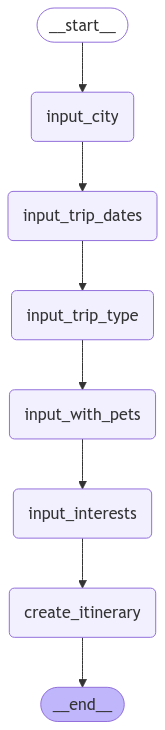

In [16]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [17]:
def run_travel_planner(user_request: str):
    print(f"Request: {user_request}\n")
    
    state = {
        "messages": [HumanMessage(content=user_request)],
        "city": "",
        "start_date": "",
        "end_date": "",
        "kind_of_trip": "",
        "with_pets": False,
        "interests": [],
        "itinerary": "",
    }

    # Stream through the workflow to process the user's input and generate an itinerary.
    for output in app.stream(state):
        pass



In [19]:
user_request = "Help me plan a trip"
run_travel_planner(user_request)

Request: Help me plan a trip

Please enter the city you want to visit for your day trip:
Danang
Please enter your trip start date (DD-MM-YYYY): 23/12/2024
Please enter your trip end date (DD-MM-YYYY): 25/12/2024
What type of trip are you planning? (Options: solo trip, partner trip, friendship trip, family trip)
solo trip
Will you bring pets along? (yes/no):
False
What are your interests for this trip? (e.g., food, history, adventure, nature):
['must-see attractions', 'great food']

Response:
# Danang Solo Trip Itinerary

**Dates:** 23rd December 2024 - 25th December 2024  
**City:** Danang  
**Trip Type:** Solo  
**Pets:** No  
**Interests:** Must-see attractions, great food

---

## Day 1: Arrival and Exploring the City

### **23rd December 2024**

- **Morning:**
  - Arrive in Danang and check into your accommodation.
  - Enjoy breakfast at **Bánh Mì Phượng** for a delicious Vietnamese sandwich.

- **Midday:**
  - Visit the **Dragon Bridge** and take photos of this iconic landmark.
  